# ANN + GMM Ensemble Model
## Chester 202018020317

# 1. Import Libraries

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import glob
from PIL import Image
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import shap

# 2. Tools Preparation

## 2.1 ReLU Activation Function
This is a custom ReLU activation function that returns the maximum of 0 and the input value.
The reason for using this custom activation function is that the GMM model requires the input to be non-negative.
The formula is as follows:
$$
f(x)=\max (0, x)
$$

Where:
- $x$ is the input value
- $f(x)$ is the output value

In [2]:
def relu(x):
    """
    Custom ReLU activation function
    :param x: input value
    :return: output value
    """
    return tf.maximum(0.0, x)

## 2.2 Swish Activation Function
This is a custom swish activation function that returns the swish of the input value.
The formula is as follows:
$$
\[
f(x)=x \cdot \sigma(x)
\]
$$

Where:
- $x$ is the input value
- $f(x)$ is the output value
- $\sigma(x)$ is the sigmoid function

In [3]:
def swish(x):
    """
    Custom swish activation function
    :param x: input value
    :return: output value
    """
    return x * tf.sigmoid(x)

## 2.3 ELU Activation Function
This is a custom ELU activation function that returns the ELU of the input value.
The formula is as follows:
$$
\[
f(x)=\left\{\begin{array}{ll}
x & \text { if } x \geq 0 \\
\alpha\left(e^{x}-1\right) & \text { if } x<0
\end{array}\right.
\]
$$

Where:
- $x$ is the input value
- $f(x)$ is the output value

In [4]:
def elu(x, alpha=1.0):
    """
    Custom ELU activation function
    :param x: input value
    :param alpha: alpha value
    :return: output value
    """
    return tf.where(x >= 0.0, x, alpha * (tf.exp(x) - 1))

## 2.4 softmax Activation Function
This is a custom softmax activation function that returns the softmax of the input value.
The reason for using this custom activation function is that the GMM model requires the input to be non-negative.
The formula is as follows:
$$
\[
\sigma(\mathbf{z})_{j}=\frac{e^{z_{j}}}{\sum_{k=1}^{K} e^{z_{k}}}
\]
$$

Where:
- $z$ is the input value
- $j$ is the $j$-th element of the input value
- $K$ is the number of elements in the input value

In [5]:
def softmax(x):
    """
    Custom softmax activation function
    :param x: input value
    :return: output value
    """
    return tf.exp(x) / tf.reduce_sum(tf.exp(x))

## 2.5 Categorical Cross Entropy Loss Function
This is a custom loss function that calculates the loss of the model's predictions.
The formula is as follows:
$$
\[
L = -\sum_{c=1}^{M} y_{\text{true}, c} \cdot \log(y_{\text{pred}, c})
\]
$$

Where:
- $M$ is the number of classes
- $y_{\text{true}, c}$ is the true label of the $c$-th class
- $y_{\text{pred}, c}$ is the predicted label of the $c$-th class

In [6]:
def categorical_Entropy_Loss_Function(y_true, y_pred):
    """
    Custom loss function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: loss
    """
    return -tf.reduce_mean(y_true * tf.math.log(y_pred))

## 2.6 Hinge Loss Function
This is a custom loss function that calculates the loss of the model's predictions.
The formula is as follows:
$$
\[
L = \max(0, 1 - y_{\text{true}} \cdot y_{\text{pred}})
\]
$$

Where:
- $y_{\text{true}}$ is the true label
- $y_{\text{pred}}$ is the predicted label
- $L$ is the loss

In [7]:
def hinge_Loss_Function(y_true, y_pred):
    """
    Custom loss function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: loss
    """
    return tf.reduce_mean(tf.maximum(0.0, 1 - y_true * y_pred))

## 2.7 Label Smoothing Cross-Entropy Loss Function
This is a custom loss function that calculates the loss of the model's predictions.
The formula is as follows:
$$
\[
L = -\sum_{c=1}^{M} y_{\text{true}, c} \cdot \log(y_{\text{pred}, c})
\]
$$

Where:
- $M$ is the number of classes
- $y_{\text{true}, c}$ is the true label of the $c$-th class
- $y_{\text{pred}, c}$ is the predicted label of the $c$-th class
- $L$ is the loss

In [8]:
def label_smoothing(y_true, y_pred, label_smoothing=0.1):
    """
    Custom loss function
    :param y_true: true labels
    :param y_pred: predicted labels
    :param label_smoothing: label smoothing factor
    :return: loss
    """
    y_true = y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

## 2.8 Custom Accuracy Function
This is a custom accuracy function that calculates the accuracy of the model's predictions.
The formula is as follows:
$$
\[
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(y_{\text{true}, i} = y_{\text{pred}, i})
\]

$$

Where:
- $N$ is the number of samples
- $y_{\text{true}, i}$ is the true label of the $i$-th sample
- $y_{\text{pred}, i}$ is the predicted label of the $i$-th sample
- $\mathbb{1}(x)$ is the indicator function, which is 1 if $x$ is true and 0 otherwise

In [9]:
def accuracy(y_true, y_pred):
    """
    Custom accuracy function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: accuracy
    """
    correct_predictions = tf.equal(tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

# 3. Model Definition

## 3.1 ANN Model
This ANN model performs the classification task by learning the complex mapping relationship between the input car label images) and the categories of the output car labels. This ANN is designed to have multiple hidden layers with multiple neurons per hidden layer (these two parameters can be changed while building the model). It is responsible for extracting features from the input image and mapping these features to the output layer, where each neuron in the output layer represents the predicted probability of a category. Since the ANN knowledge integrates a part of the model, the output of the ANN (feature vector) is not used directly for classification decisions but as input to the GMM.

In [10]:
class ANNClassifier:
    def __init__(self, input_shape, num_classes, hidden_layers_sizes):
        """
        The constructor of the ANNClassifier class.
        :param input_shape: The shape of the input data
        :param num_classes: The number of classes
        :param hidden_layers_sizes: The sizes of the hidden layers
        """
        self.model = Sequential()
        self.model.add(Flatten(input_shape=input_shape))
        for i, layer_size in enumerate(hidden_layers_sizes):
            if i % 2 == 0:
                self.model.add(Dense(layer_size, activation=swish))
            else:
                self.model.add(Dense(layer_size, activation='elu'))
        self.model.add(Dense(num_classes, activation=softmax))

    def compile(self, optimizer):
        """
        Compiles the model.
        :param optimizer: The optimizer to use
        """
        self.model.compile(optimizer=optimizer, loss=categorical_Entropy_Loss_Function, metrics=[accuracy])

    def fit(self, X, y, epochs, batch_size, validation_data):
        """
        Fits the model to the training data.
        :param X: the training data
        :param y: the training labels
        :param epochs: the number of epochs
        :param batch_size: the batch size
        :param validation_data: the validation data and labels
        :return: the history of the training process
        """
        self.history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return self.history

    def explain(self, X):
        """
        Explains the model's predictions.
        :param X: the data used for prediction
        :return: the explanation
        """
        explainer = shap.DeepExplainer(self.model, X)
        return explainer.shap_values(X)

    def predict(self, X):
        """
        Predicts the labels of the data.
        :param X: the data used for prediction
        :return: the predicted labels
        """
        return self.model.predict(X)

## 3.2 GMM Model
In this integrated model, the role of the GMM is to cluster the output of the ANN. Specifically, it clusters the feature vectors of the ANN output into a number of classes, each representing a set of car labels with similar features.

In [11]:
class GMMClassifier:
    def __init__(self, n_components):
        """
        The constructor of the GMMClassifier class.
        :param n_components: The number of components
        """
        self.gmm = GaussianMixture(n_components=n_components)

    def fit(self, X):
        self.gmm.fit(X)

    def predict(self, X):
        return self.gmm.predict(X)

## 3.3 Ensemble Model
This is the integrated model that combines the ANN and GMM models. It takes the ANN and GMM models as input and uses the ANN model to extract features from the input data and the GMM model to cluster the extracted features.

In [12]:
class Ensemble:
    def __init__(self, supervised_model, unsupervised_model):
        """
        The constructor of the Ensemble class.
        :param supervised_model: the supervised model - ANN
        :param unsupervised_model: the unsupervised model - GMM
        """
        self.supervised_model = supervised_model
        self.unsupervised_model = unsupervised_model

    def fit(self, X, y, epochs, batch_size, validation_data):
        """
        Fits the model to the training data.
        :param X: the training data
        :param y: the training labels
        :param epochs: the number of epochs in the ANN
        :param batch_size: the batch size in the ANN
        :return: the history of the training process
        """
        loss_history = self.supervised_model.fit(X, y, epochs, batch_size, validation_data=validation_data)
        features = self.supervised_model.predict(X)
        print(features.shape)
        self.unsupervised_model.fit(features)

        return loss_history

    def predict(self, X):
        """
        Predicts the labels of the data.
        :param X: the data used for prediction
        :return: the predicted labels
        """
        # Get ANN predictions to use as features for GMM
        predictions = self.supervised_model.predict(X)
        # Predict with GMM
        return self.unsupervised_model.predict(predictions)

# 4. Data Processing
## 4.1 Load & Preprocess Data 
This section contains the code for loading and preprocessing the data.

In [13]:
def load_images(image_paths, target_size):
    images = []
    labels = []
    for image_path in image_paths:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img)
        images.append(img_array)
        label = os.path.basename(os.path.dirname(image_path))
        labels.append(label)

    # Normalize pixel values
    images = np.array(images, dtype='float32') / 255.0
    # Convert labels to integer encoding
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels)
    return images, labels


# Load images
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths, target_size=(32, 32))

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print(X[1])
print(X.shape)
print(y[1])
print(y.shape)

[[[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 ...

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]


## 4.2 Data visualization

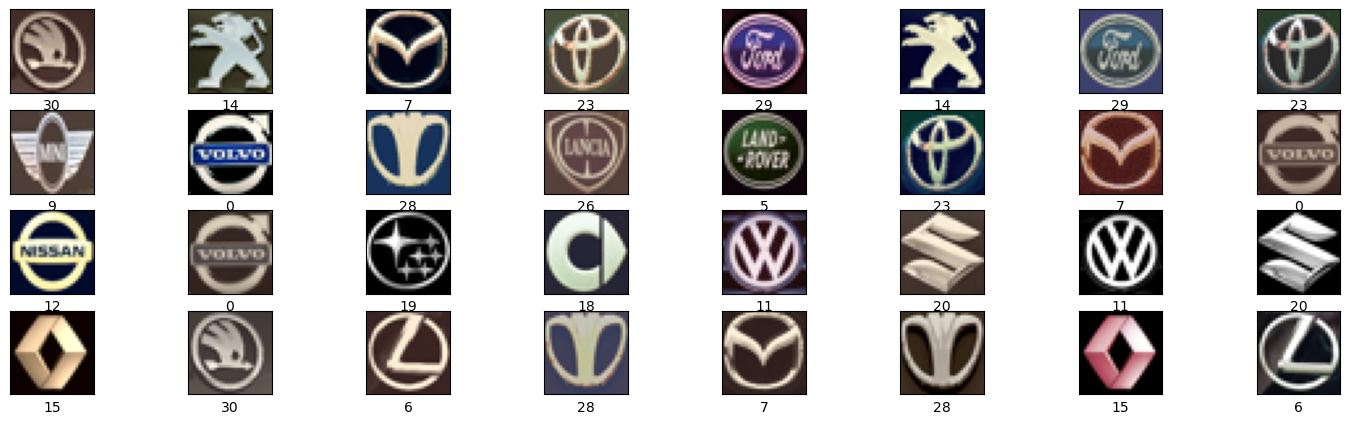

In [15]:
plt.figure(figsize=(18, 5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(np.argmax(y_train[i]))

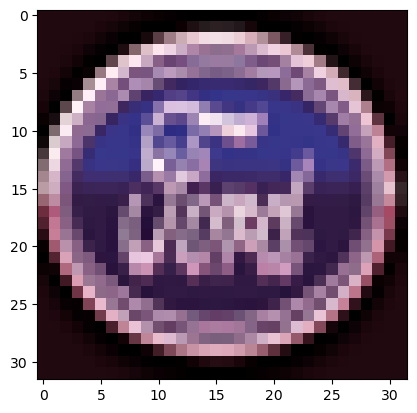

In [16]:
plt.imshow(X_train[4])

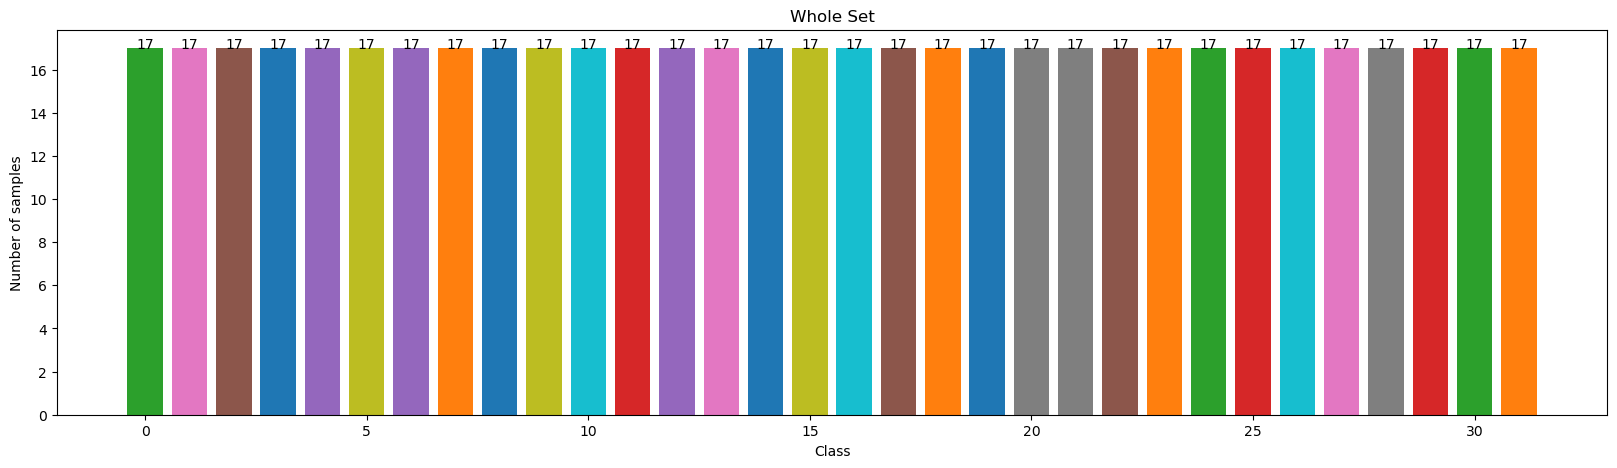

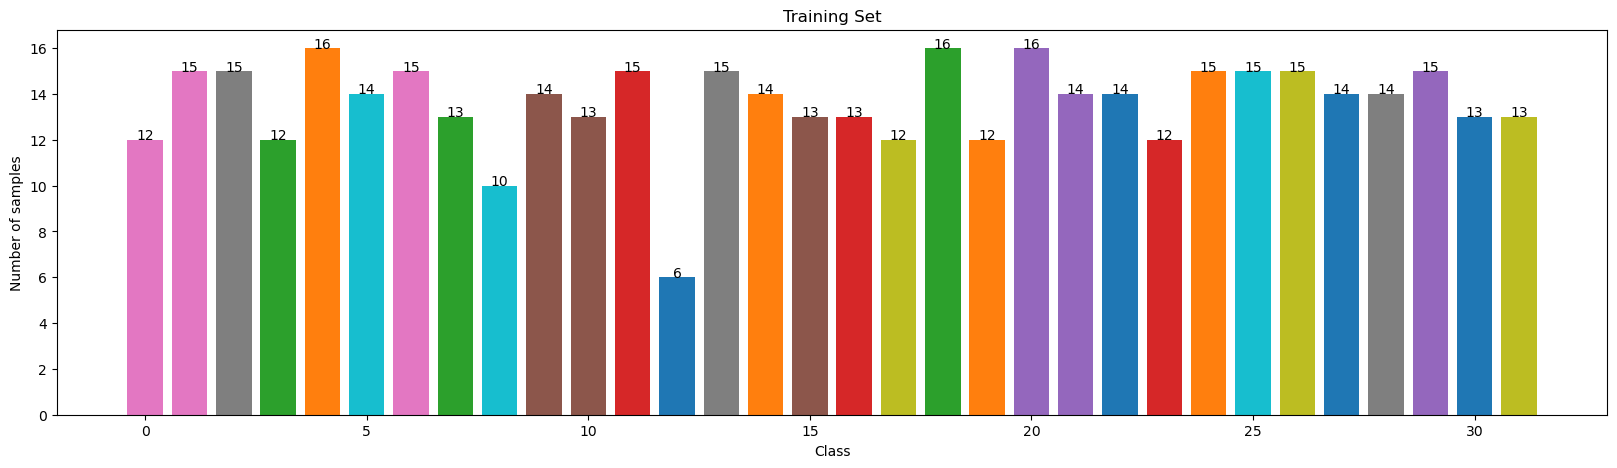

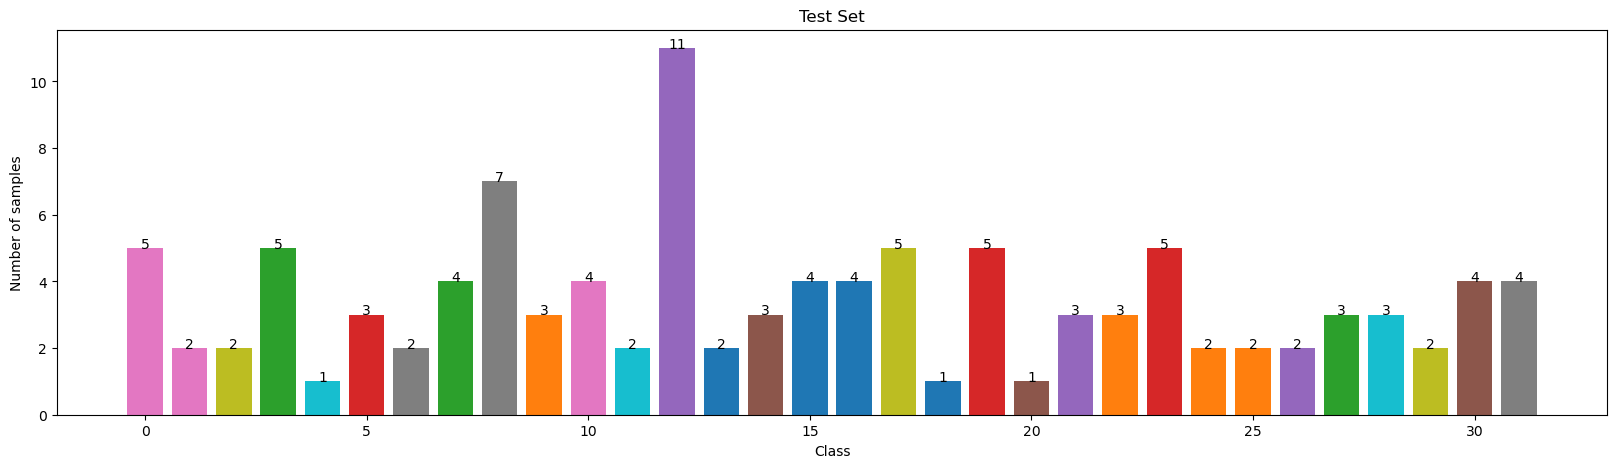

In [17]:
class DistributionPlotter:
    def __init__(self, y):
        self.y = y

    def plot(self, title=""):
        counter = Counter(self.y)
        numbers = list(counter.values())
        labels = list(counter.keys())
        colors = [f'C{i}' for i in range(len(numbers))]

        plt.figure(figsize=(20, 5))
        plt.bar(labels, numbers, color=colors)

        for i in range(len(numbers)):
            plt.text(labels[i], numbers[i], numbers[i], ha='center')

        plt.title(title)
        plt.xlabel('Class')
        plt.ylabel('Number of samples')
        plt.show()


DistributionPlotter(np.argmax(y, axis=1)).plot(title="Whole Set")
DistributionPlotter(np.argmax(y_train, axis=1)).plot(title="Training Set")
DistributionPlotter(np.argmax(y_test, axis=1)).plot(title="Test Set")

# 5. Model Building
## 5.1 Model Construction

In [18]:
ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                    hidden_layers_sizes=(128, 128))
ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.009))
gmm = GMMClassifier(n_components=2)
ensemble = Ensemble(ann, gmm)

2023-12-13 13:58:56.771066: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-13 13:58:56.771089: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-13 13:58:56.771094: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-13 13:58:56.771463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-13 13:58:56.771810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 5.2 Model Training

In [19]:
history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
y_pred = ensemble.predict(X_test)
y_test = np.argmax(y_test, axis=1)

Epoch 1/40


2023-12-13 13:58:57.359862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 35ms/step - loss: 0.4123 - accuracy: 0.0939 - val_loss: 0.2059 - val_accuracy: 0.2921
Epoch 2/40
 6/14 [===========>..................] - ETA: 0s - loss: 0.2158 - accuracy: 0.2552

2023-12-13 13:58:57.999378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 13ms/step - loss: 0.2042 - accuracy: 0.2434 - val_loss: 0.1847 - val_accuracy: 0.2921
Epoch 3/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1828 - accuracy: 0.4088 - val_loss: 0.1632 - val_accuracy: 0.5096
Epoch 4/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1588 - accuracy: 0.6180 - val_loss: 0.1519 - val_accuracy: 0.5685
Epoch 5/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1500 - accuracy: 0.7432 - val_loss: 0.1365 - val_accuracy: 0.8636
Epoch 6/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1444 - accuracy: 0.7856 - val_loss: 0.1358 - val_accuracy: 0.8870
Epoch 7/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1416 - accuracy: 0.8191 - val_loss: 0.1333 - val_accuracy: 0.9297
Epoch 8/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1353 - accuracy: 0.8622 - val_loss: 0.1312 - val_accuracy: 0.9183
Epoch 9/40
14/14 [======

2023-12-13 13:59:05.073938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 8ms/step


# 6. Model Evaluation
## 6.1 Plot History

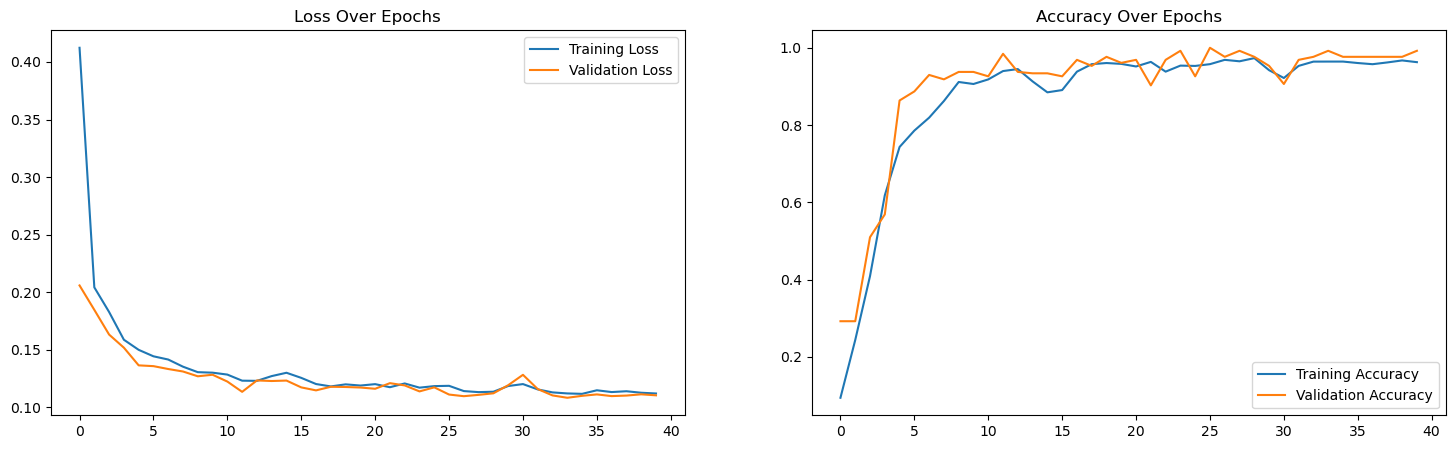

ANN Final cost: 0.1120757907629013
ANN Validation Loss: 0.11048616468906403
ANN Final accuracy: 0.962758481502533
ANN Validation accuracy: 0.9921875


In [20]:
def plot_history(history):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()


plot_history(history)
print('ANN Final cost:', history.history['loss'][-1])
print('ANN Validation Loss:', history.history['val_loss'][-1])
print('ANN Final accuracy:', history.history['accuracy'][-1])
print('ANN Validation accuracy:', history.history['val_accuracy'][-1])

## 6.2 Remap Labels
Due to the nature of the unsupervised model, the predicted labels may not be the same as the true labels. This function remaps the predicted labels to the true labels.

In [21]:
def remap_labels(true_labels, predicted_labels):
    unique_true_labels = np.unique(true_labels)
    mapped_labels = np.zeros_like(predicted_labels)

    for true_label in unique_true_labels:
        mask = (true_labels == true_label)
        predicted_labels_for_true_label = predicted_labels[mask]
        unique_predicted, counts = np.unique(predicted_labels_for_true_label, return_counts=True)
        most_common = unique_predicted[np.argmax(counts)]
        mapped_labels[predicted_labels == most_common] = true_label

    return mapped_labels


mapped_predictions = remap_labels(y_test, y_pred)

In [22]:
print("True labels:")
print(y_test)
print("Predicted labels:")
print(y_pred)
print("Remapped predicted labels:")
print(mapped_predictions)

True labels:
[13 22  7 23 23 12 20 12 12  0  8  2  4 12 23  2 15 25  3 19 12 21 15  0
 30  8  1  3  8  3 12  6 12 17 19 11 15 19 21 16  9 27  5 26 16 14  9 10
  7  9 31 29 12 12  3 13  8 16 14 23 30  6 10 30 19 23 17 28  0 18 11 12
 28 10 29 12 19 25 28 17 27  3 31 10  5  8  8 22 31  7  0 17  1 15 22 21
  7  0 31 30  5  8 14 24 16 27 24 17 26]
Predicted labels:
[1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Remapped predicted labels:
[31 31 31 31 31 26 31 26 26 31 31 31 31 26 31 31 31 31 31 31 26 31 31 31
 31 31 31 31 31 31 26 31 26 31 31 31 31 31 31 31 31 31 31 26 31 31 31 31
 31 26 31 31 26 26 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 26
 31 31 31 26 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 26]


## 6.3 Confusion Matrix

Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50         11
        14       0.00       0.00       0.00       0.50         

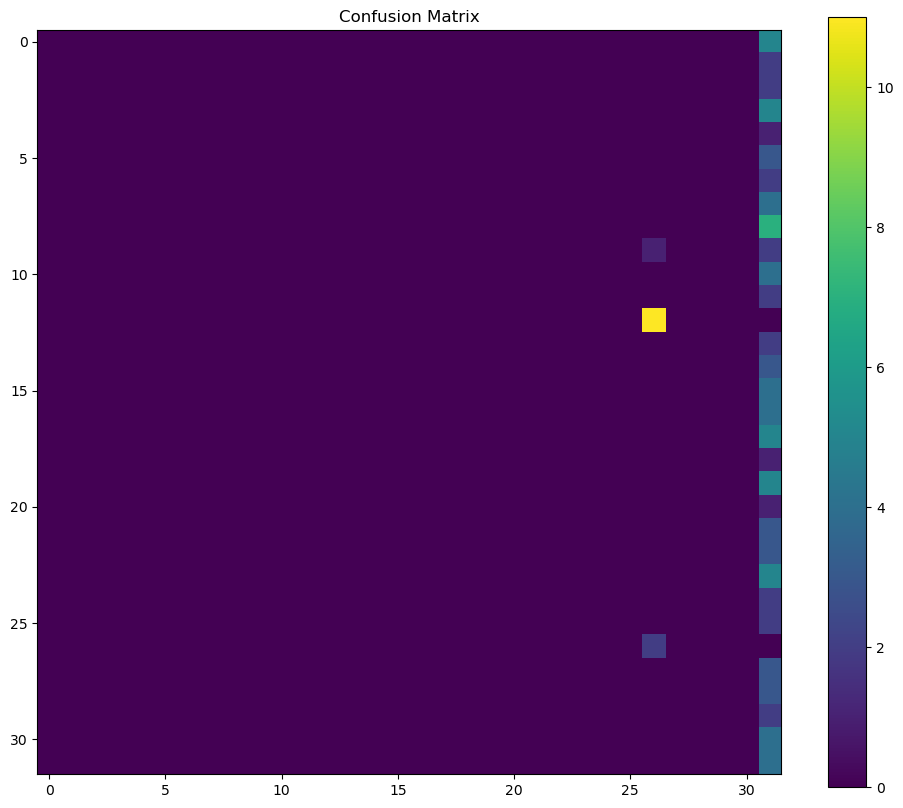

In [23]:
def confusion_matrix(y_true, y_pred):
    """
    Compute and print the confusion matrix, classification report, and estimate ROC AUC.
    
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the confusion matrix
    """
    num_classes = len(np.unique(y_true))
    result = np.zeros((num_classes, num_classes))
    roc_auc_scores = np.zeros(num_classes)

    for i in range(len(y_true)):
        result[y_true[i]][y_pred[i]] += 1

    true_positive = np.diag(result)
    false_positive = np.sum(result, axis=0) - true_positive
    false_negative = np.sum(result, axis=1) - true_positive
    true_negative = np.sum(result) - (true_positive + false_positive + false_negative)

    epsilon = 1e-7
    recall = true_positive / (true_positive + false_negative + epsilon)
    precision = true_positive / (true_positive + false_positive + epsilon)
    f1_score = 2 * precision * recall / (precision + recall + epsilon)
    support = np.sum(result, axis=1)

    print("Model Report")
    print("=" * 80)
    print("{:>10} {:>10} {:>10} {:>10} {:>10} {:>10}".format('Class', 'Precision', 'Recall', 'F1-Score', 'ROC AUC',
                                                             'Support'))
    for i in range(num_classes):
        TPR = recall[i]
        FPR = false_positive[i] / (false_positive[i] + true_negative[i] + epsilon)
        roc_auc = (1 + TPR - FPR) / 2
        roc_auc_scores[i] = roc_auc

        print("{:>10d} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f} {:>10d}".format(i + 1, precision[i], recall[i],
                                                                               f1_score[i], roc_auc, int(support[i])))

    print("=" * 80)
    print("Avg Recall: {:.2f}".format(np.mean(recall)))
    print("Avg Precision: {:.2f}".format(np.mean(precision)))
    print("Avg F1-Score: {:.2f}".format(np.mean(f1_score)))
    print("Avg ROC AUC: {:.2f}".format(np.mean(roc_auc_scores)))

    return result


conf_matrix = confusion_matrix(y_test, mapped_predictions)
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# 6.4 Accuracy
This is a custom accuracy function that calculates the accuracy of the model's predictions.
The formula is as follows:
$$
\[
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(y_{\text{true}, i} = y_{\text{pred}, i})
\]

$$

Where:
- $N$ is the number of samples
- $y_{\text{true}, i}$ is the true label of the $i$-th sample
- $y_{\text{pred}, i}$ is the predicted label of the $i$-th sample

In [24]:
def custom_accuracy(y_true, y_pred):
    """
    Custom accuracy function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: accuracy
    """
    correct_predictions = tf.equal(y_true, y_pred)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32)) * 100


print(f"Accuracy: {custom_accuracy(y_test, mapped_predictions).numpy():.3f}%")

Accuracy: 5.505%


# 6.5 Visualization

4/4 [==============================] - 0s 4ms/step


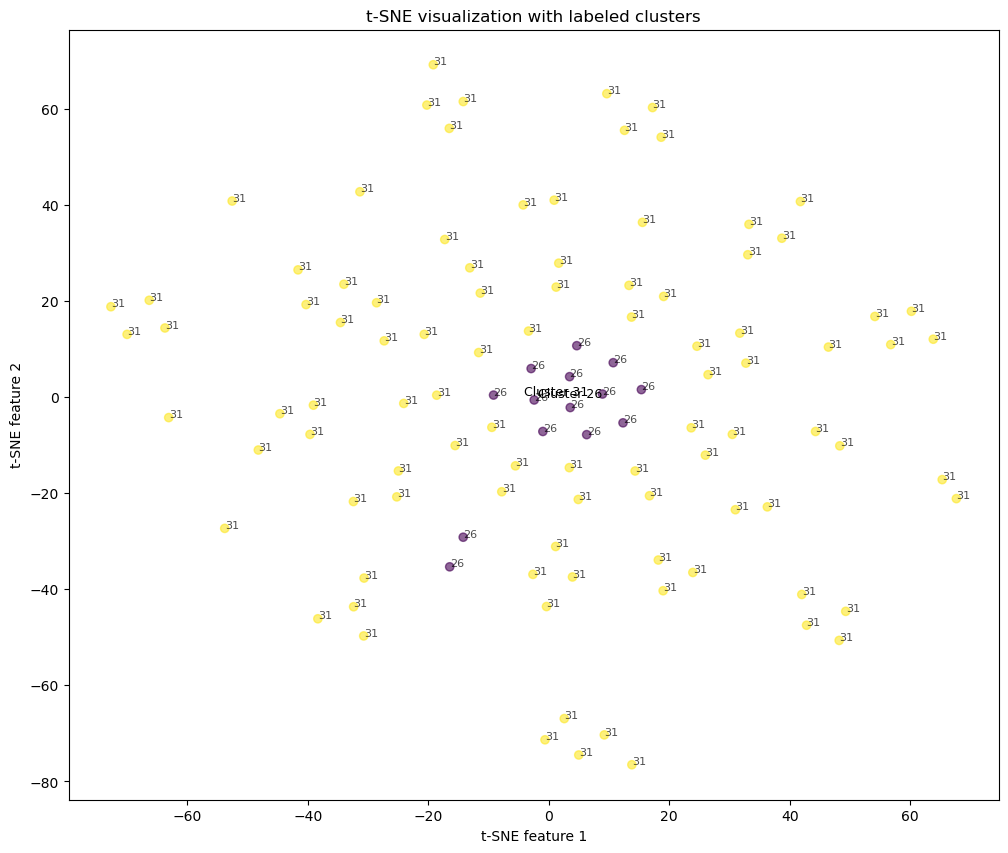

In [25]:
def visualize_clusters_with_labels(X, y, model):
    features = model.predict(X)

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    X_reduced = tsne.fit_transform(features)

    plt.figure(figsize=(12, 10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.6)

    unique_labels = np.unique(y)
    for i, label in enumerate(unique_labels):
        xtext, ytext = np.median(X_reduced[y == label, :], axis=0)
        txt = f'Cluster {label}'
        plt.annotate(txt, (xtext, ytext), fontsize=9, ha='center')

    for i, txt in enumerate(y):
        plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8, alpha=0.7)

    plt.title('t-SNE visualization with labeled clusters')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()


visualize_clusters_with_labels(X_test, mapped_predictions, ann)

# 7. Hyperparameter Test

In [26]:
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths, target_size=(32, 32))

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 7.1 Set different hidden layers of ANN

Epoch 1/40


2023-12-13 13:59:07.645876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 32ms/step - loss: 0.1965 - accuracy: 0.4418 - val_loss: 0.1697 - val_accuracy: 0.7740
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.1664 - accuracy: 0.9062

2023-12-13 13:59:08.093206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 12ms/step - loss: 0.1495 - accuracy: 0.9464 - val_loss: 0.1348 - val_accuracy: 0.8948
Epoch 3/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1279 - accuracy: 0.9911 - val_loss: 0.1233 - val_accuracy: 0.9922
Epoch 4/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1229 - accuracy: 1.0000 - val_loss: 0.1193 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1205 - accuracy: 1.0000 - val_loss: 0.1201 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1207 - accuracy: 1.0000 - val_loss: 0.1159 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1186 - accuracy: 1.0000 - val_loss: 0.1191 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1197 - accuracy: 1.0000 - val_loss: 0.1145 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-13 13:59:15.300971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 13ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-13 13:59:16.099887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 33ms/step - loss: 0.2022 - accuracy: 0.4433 - val_loss: 0.1820 - val_accuracy: 0.6809
Epoch 2/40
 5/14 [=========>....................] - ETA: 0s - loss: 0.1752 - accuracy: 0.7688

2023-12-13 13:59:16.676771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 14ms/step - loss: 0.1613 - accuracy: 0.8690 - val_loss: 0.1443 - val_accuracy: 0.8948
Epoch 3/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1336 - accuracy: 0.9828 - val_loss: 0.1279 - val_accuracy: 1.0000
Epoch 4/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1253 - accuracy: 1.0000 - val_loss: 0.1210 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1227 - accuracy: 1.0000 - val_loss: 0.1259 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1247 - accuracy: 0.9911 - val_loss: 0.1244 - val_accuracy: 0.9922
Epoch 7/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1211 - accuracy: 1.0000 - val_loss: 0.1154 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1183 - accuracy: 1.0000 - val_loss: 0.1151 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-13 13:59:24.563434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 14ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.83       1.00       0.91       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-13 13:59:26.895133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 37ms/step - loss: 0.2031 - accuracy: 0.3943 - val_loss: 0.1822 - val_accuracy: 0.7157
Epoch 2/40
 5/14 [=========>....................] - ETA: 0s - loss: 0.1766 - accuracy: 0.8625

2023-12-13 13:59:27.488879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 17ms/step - loss: 0.1627 - accuracy: 0.9226 - val_loss: 0.1462 - val_accuracy: 0.9062
Epoch 3/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1323 - accuracy: 0.9866 - val_loss: 0.1220 - val_accuracy: 1.0000
Epoch 4/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1231 - accuracy: 0.9955 - val_loss: 0.1207 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1226 - accuracy: 1.0000 - val_loss: 0.1222 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1225 - accuracy: 0.9978 - val_loss: 0.1164 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1179 - accuracy: 1.0000 - val_loss: 0.1171 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1183 - accuracy: 0.9888 - val_loss: 0.1132 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-13 13:59:36.503462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 16ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-13 13:59:37.212586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 42ms/step - loss: 0.2083 - accuracy: 0.2966 - val_loss: 0.1944 - val_accuracy: 0.4543
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.1941 - accuracy: 0.4375

2023-12-13 13:59:37.862239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 18ms/step - loss: 0.1792 - accuracy: 0.6434 - val_loss: 0.1618 - val_accuracy: 0.7157
Epoch 3/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1442 - accuracy: 0.9159 - val_loss: 0.1339 - val_accuracy: 0.8906
Epoch 4/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1270 - accuracy: 0.9844 - val_loss: 0.1223 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1213 - accuracy: 0.9978 - val_loss: 0.1156 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1188 - accuracy: 1.0000 - val_loss: 0.1150 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1181 - accuracy: 1.0000 - val_loss: 0.1143 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1156 - accuracy: 1.0000 - val_loss: 0.1121 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-13 13:59:47.486408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 15ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-13 13:59:48.329771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 44ms/step - loss: 0.2068 - accuracy: 0.1617 - val_loss: 0.1940 - val_accuracy: 0.3311
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.1890 - accuracy: 0.4375

2023-12-13 13:59:49.026062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 17ms/step - loss: 0.1814 - accuracy: 0.6136 - val_loss: 0.1689 - val_accuracy: 0.6647
Epoch 3/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1578 - accuracy: 0.8675 - val_loss: 0.1503 - val_accuracy: 0.9141
Epoch 4/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1403 - accuracy: 0.9933 - val_loss: 0.1328 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1289 - accuracy: 1.0000 - val_loss: 0.1244 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1232 - accuracy: 1.0000 - val_loss: 0.1184 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1196 - accuracy: 1.0000 - val_loss: 0.1153 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1184 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-13 13:59:57.608427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 19ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       0.00       0.00       0.00       0.50         11
        14 

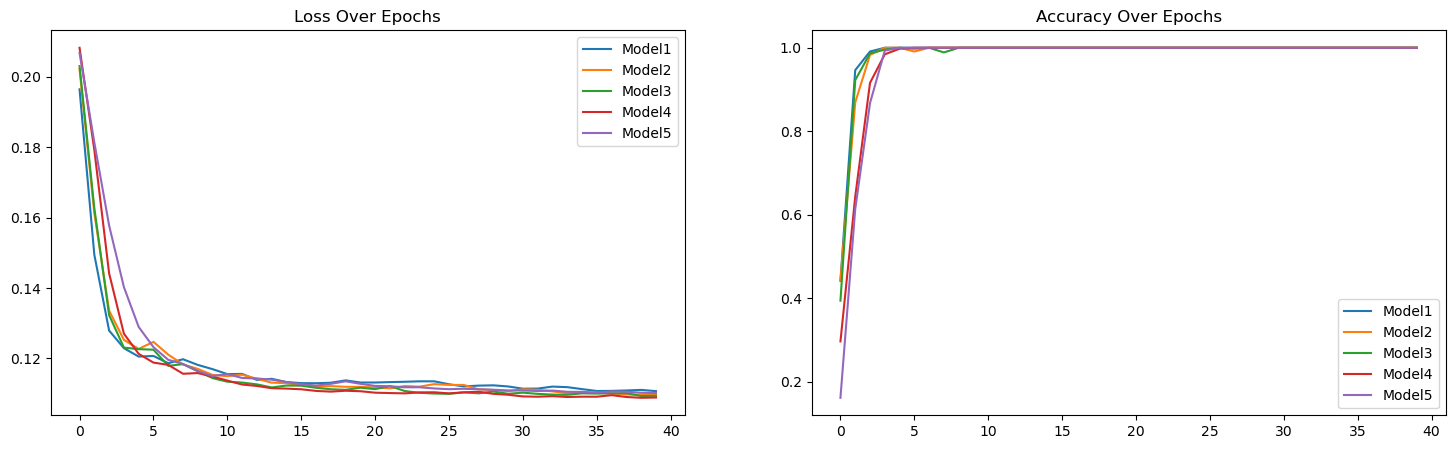

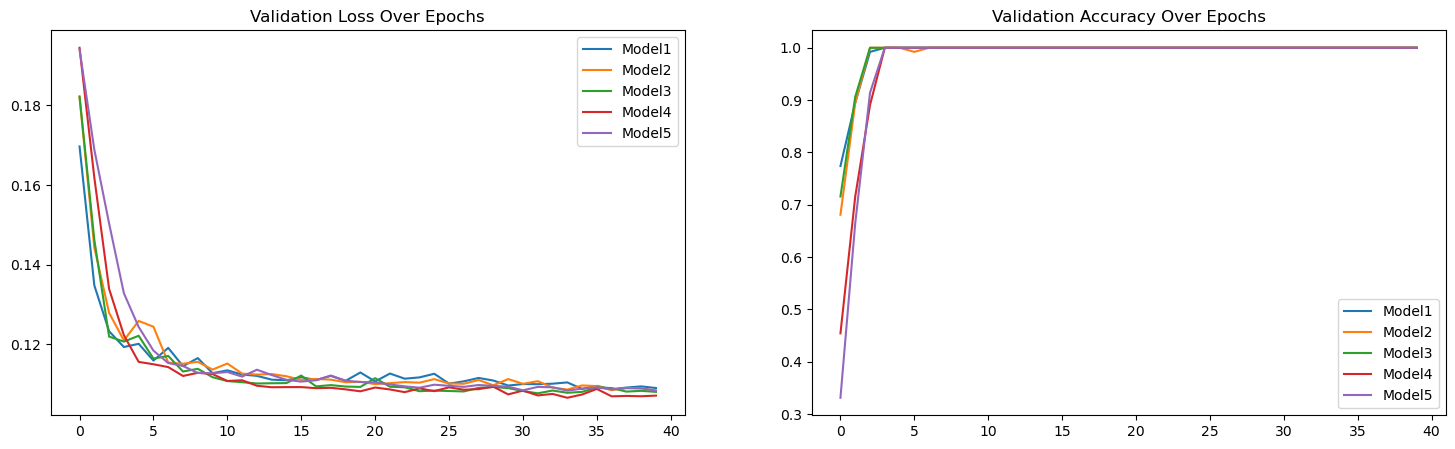

Final validation loss of Model1: 0.1091
Final validation loss of Model2: 0.1084
Final validation loss of Model3: 0.1081
Final validation loss of Model4: 0.1072
Final validation loss of Model5: 0.1084
Final accuracy of Model1: 100.000%
Final accuracy of Model2: 95.413%
Final accuracy of Model3: 100.000%
Final accuracy of Model4: 100.000%
Final accuracy of Model5: 89.908%


In [27]:
def test_model(hidden_layers_sizes):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=hidden_layers_sizes)
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model((128, 128))
Model2_history, Model2_accuracy = test_model((128, 128, 128))
Model3_history, Model3_accuracy = test_model((128, 128, 128, 128))
Model4_history, Model4_accuracy = test_model((128, 128, 128, 128, 128))
Model5_history, Model5_accuracy = test_model((128, 64, 32, 32))

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.plot(Model4_history.history['loss'], label='Model4')
plt.plot(Model5_history.history['loss'], label='Model5')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.plot(Model4_history.history['accuracy'], label='Model4')
plt.plot(Model5_history.history['accuracy'], label='Model5')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['val_loss'], label='Model1')
plt.plot(Model2_history.history['val_loss'], label='Model2')
plt.plot(Model3_history.history['val_loss'], label='Model3')
plt.plot(Model4_history.history['val_loss'], label='Model4')
plt.plot(Model5_history.history['val_loss'], label='Model5')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['val_accuracy'], label='Model1')
plt.plot(Model2_history.history['val_accuracy'], label='Model2')
plt.plot(Model3_history.history['val_accuracy'], label='Model3')
plt.plot(Model4_history.history['val_accuracy'], label='Model4')
plt.plot(Model5_history.history['val_accuracy'], label='Model5')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()
print("Final validation loss of Model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Final validation loss of Model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Final validation loss of Model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Final validation loss of Model4:", f"{Model4_history.history['val_loss'][-1]:.4f}")
print("Final validation loss of Model5:", f"{Model5_history.history['val_loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")
print("Final accuracy of Model4:", f"{Model4_accuracy:.3f}%")
print("Final accuracy of Model5:", f"{Model5_accuracy:.3f}%")

## 7.2 Set different learning rates of ANN

Epoch 1/40


2023-12-13 13:59:59.067446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 47ms/step - loss: 0.2138 - accuracy: 0.0874 - val_loss: 0.2084 - val_accuracy: 0.2175
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.2109 - accuracy: 0.2500

2023-12-13 13:59:59.821068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 18ms/step - loss: 0.2057 - accuracy: 0.3582 - val_loss: 0.2003 - val_accuracy: 0.4736
Epoch 3/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1934 - accuracy: 0.6828 - val_loss: 0.1861 - val_accuracy: 0.6803
Epoch 4/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1756 - accuracy: 0.7915 - val_loss: 0.1687 - val_accuracy: 0.7386
Epoch 5/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1562 - accuracy: 0.8898 - val_loss: 0.1518 - val_accuracy: 0.8167
Epoch 6/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1410 - accuracy: 0.9494 - val_loss: 0.1376 - val_accuracy: 0.8948
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1307 - accuracy: 0.9799 - val_loss: 0.1293 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1249 - accuracy: 1.0000 - val_loss: 0.1216 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-13 14:00:09.239279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 24ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       0.00       0.00       0.00       0.50         

2023-12-13 14:00:10.128865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 48ms/step - loss: 0.2086 - accuracy: 0.3711 - val_loss: 0.1951 - val_accuracy: 0.5060
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.1954 - accuracy: 0.5312

2023-12-13 14:00:10.857851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 20ms/step - loss: 0.1784 - accuracy: 0.6398 - val_loss: 0.1583 - val_accuracy: 0.8053
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1434 - accuracy: 0.9337 - val_loss: 0.1328 - val_accuracy: 0.9609
Epoch 4/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1273 - accuracy: 0.9978 - val_loss: 0.1206 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1231 - accuracy: 0.9955 - val_loss: 0.1173 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1194 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 22ms/step - loss: 0.1171 - accuracy: 1.0000 - val_loss: 0.1128 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1156 - accuracy: 1.0000 - val_loss: 0.1171 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-13 14:00:20.914154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 18ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-13 14:00:21.826675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 48ms/step - loss: 0.2016 - accuracy: 0.3432 - val_loss: 0.1750 - val_accuracy: 0.5445
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.1720 - accuracy: 0.7500

2023-12-13 14:00:22.584534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 20ms/step - loss: 0.1583 - accuracy: 0.7632 - val_loss: 0.1487 - val_accuracy: 0.7662
Epoch 3/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1363 - accuracy: 0.9286 - val_loss: 0.1305 - val_accuracy: 0.9766
Epoch 4/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1242 - accuracy: 0.9866 - val_loss: 0.1174 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1186 - accuracy: 1.0000 - val_loss: 0.1156 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1226 - accuracy: 0.9784 - val_loss: 0.1192 - val_accuracy: 0.9922
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1218 - accuracy: 0.9978 - val_loss: 0.1168 - val_accuracy: 0.9922
Epoch 8/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1175 - accuracy: 1.0000 - val_loss: 0.1164 - val_accuracy: 0.9766
Epoch 9/40
14/14 [======

2023-12-13 14:00:32.095266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 21ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
 

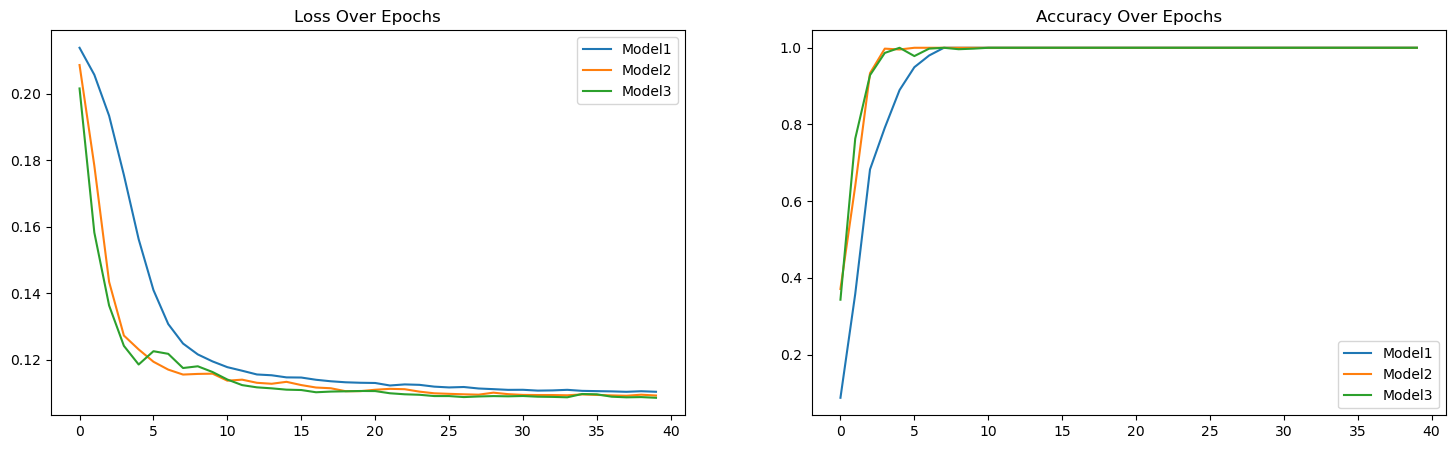

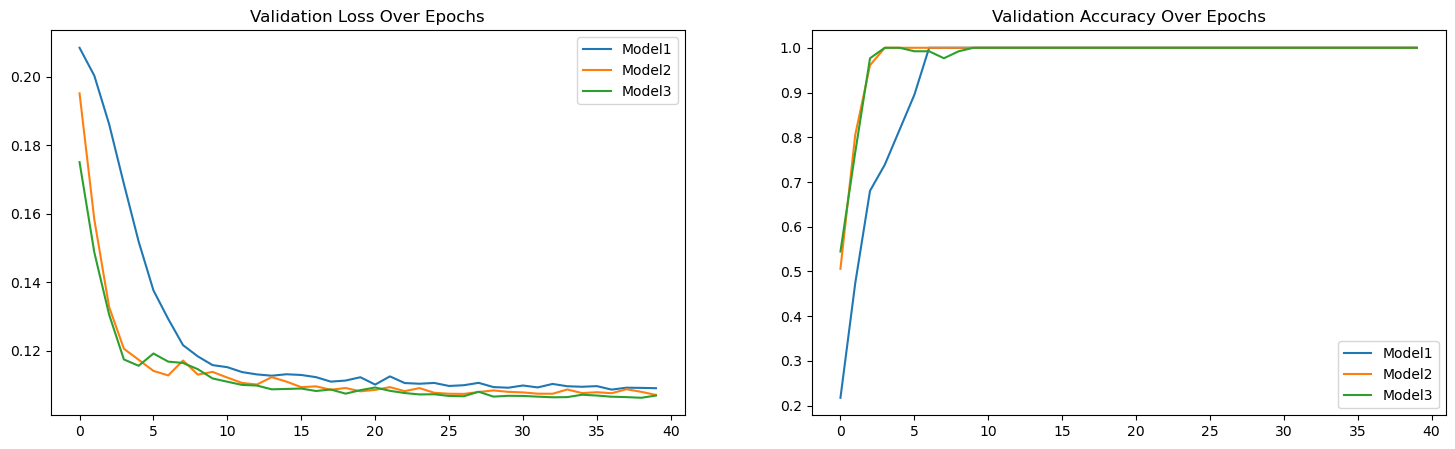

Final loss of Model1: 0.1090
Final loss of Model2: 0.1071
Final loss of Model3: 0.1069
Final accuracy of Model1: 98.165%
Final accuracy of Model2: 100.000%
Final accuracy of Model3: 100.000%


In [28]:
def test_model(learning_rate):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(0.0001)
Model2_history, Model2_accuracy = test_model(0.0003)
Model3_history, Model3_accuracy = test_model(0.0005)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['val_loss'], label='Model1')
plt.plot(Model2_history.history['val_loss'], label='Model2')
plt.plot(Model3_history.history['val_loss'], label='Model3')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['val_accuracy'], label='Model1')
plt.plot(Model2_history.history['val_accuracy'], label='Model2')
plt.plot(Model3_history.history['val_accuracy'], label='Model3')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()
print("Final loss of Model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")

## 7.3 Set different batch sizes of ANN

Epoch 1/40


2023-12-13 14:00:33.324602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 1s 33ms/step - loss: 0.1776 - accuracy: 0.3609 - val_loss: 0.1570 - val_accuracy: 0.5522
Epoch 2/40
 1/28 [>.............................] - ETA: 0s - loss: 0.1435 - accuracy: 0.8125

2023-12-13 14:00:34.375844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 16ms/step - loss: 0.1278 - accuracy: 0.8609 - val_loss: 0.1135 - val_accuracy: 0.8640
Epoch 3/40
28/28 [==============================] - 0s 17ms/step - loss: 0.1039 - accuracy: 0.9866 - val_loss: 0.0993 - val_accuracy: 1.0000
Epoch 4/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0980 - accuracy: 1.0000 - val_loss: 0.0972 - val_accuracy: 1.0000
Epoch 5/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0978 - accuracy: 0.9978 - val_loss: 0.0952 - val_accuracy: 1.0000
Epoch 6/40
28/28 [==============================] - 0s 17ms/step - loss: 0.0953 - accuracy: 1.0000 - val_loss: 0.0937 - val_accuracy: 1.0000
Epoch 7/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0941 - accuracy: 1.0000 - val_loss: 0.0962 - val_accuracy: 1.0000
Epoch 8/40
28/28 [==============================] - 0s 17ms/step - loss: 0.0952 - accuracy: 0.9955 - val_loss: 0.0983 - val_accuracy: 1.0000
Epoch 9/40
28/28 [======

2023-12-13 14:00:51.561459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 24ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       0.00       0.00       0.00       0.50         11
 

Epoch 1/40


2023-12-13 14:00:52.518091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 48ms/step - loss: 0.2087 - accuracy: 0.3188 - val_loss: 0.1951 - val_accuracy: 0.4471
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.1953 - accuracy: 0.5000

2023-12-13 14:00:53.343594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 21ms/step - loss: 0.1762 - accuracy: 0.6994 - val_loss: 0.1585 - val_accuracy: 0.7933
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1417 - accuracy: 0.9516 - val_loss: 0.1293 - val_accuracy: 0.9922
Epoch 4/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1250 - accuracy: 0.9978 - val_loss: 0.1202 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1213 - accuracy: 1.0000 - val_loss: 0.1196 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1194 - accuracy: 0.9933 - val_loss: 0.1215 - val_accuracy: 0.9688
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1180 - accuracy: 0.9955 - val_loss: 0.1158 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1167 - accuracy: 1.0000 - val_loss: 0.1164 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-13 14:01:02.864723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 20ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       0.00       0.00       0.00       0.50          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       0.78       1.00       0.87       0.99          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-13 14:01:03.593689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 90ms/step - loss: 0.2324 - accuracy: 0.1893 - val_loss: 0.2230 - val_accuracy: 0.2806
Epoch 2/40
1/7 [===>..........................] - ETA: 0s - loss: 0.2221 - accuracy: 0.4844

2023-12-13 14:01:04.315345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 25ms/step - loss: 0.2152 - accuracy: 0.5567 - val_loss: 0.2071 - val_accuracy: 0.5957
Epoch 3/40
7/7 [==============================] - 0s 27ms/step - loss: 0.1925 - accuracy: 0.7482 - val_loss: 0.1893 - val_accuracy: 0.6714
Epoch 4/40
7/7 [==============================] - 0s 22ms/step - loss: 0.1710 - accuracy: 0.8855 - val_loss: 0.1719 - val_accuracy: 0.8351
Epoch 5/40
7/7 [==============================] - 0s 21ms/step - loss: 0.1563 - accuracy: 0.9659 - val_loss: 0.1604 - val_accuracy: 0.8540
Epoch 6/40
7/7 [==============================] - 0s 21ms/step - loss: 0.1486 - accuracy: 0.9631 - val_loss: 0.1528 - val_accuracy: 0.8997
Epoch 7/40
7/7 [==============================] - 0s 20ms/step - loss: 0.1442 - accuracy: 0.9866 - val_loss: 0.1459 - val_accuracy: 0.9075
Epoch 8/40
7/7 [==============================] - 0s 21ms/step - loss: 0.1421 - accuracy: 0.9955 - val_loss: 0.1397 - val_accuracy: 1.0000
Epoch 9/40
7/7 [======================

2023-12-13 14:01:09.767647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 24ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       0.00       0.00       0.00       0.50          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
 

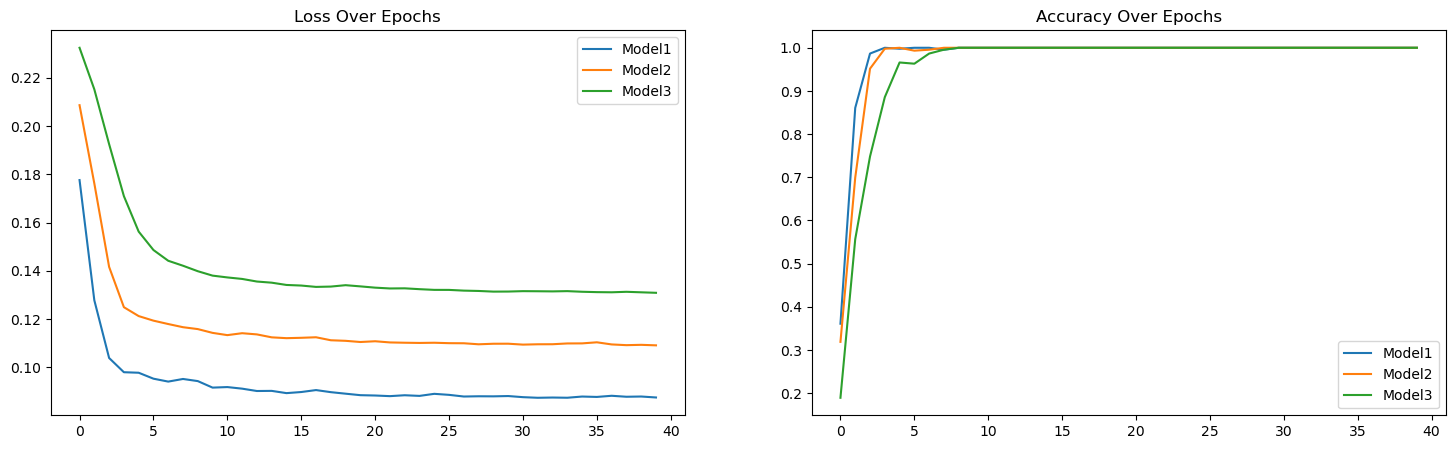

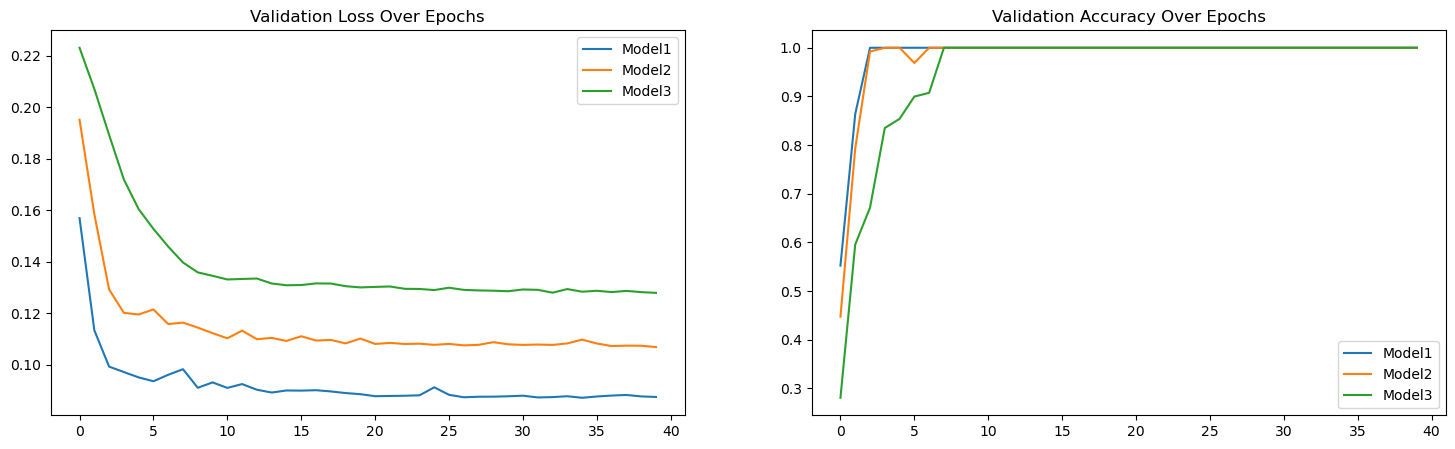

Final loss of Model1: 0.0876
Final loss of Model2: 0.1069
Final loss of Model3: 0.1280
Final accuracy of Model1: 89.908%
Final accuracy of Model2: 98.165%
Final accuracy of Model3: 97.248%


In [29]:
def test_model(batch_size):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=batch_size, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(16)
Model2_history, Model2_accuracy = test_model(32)
Model3_history, Model3_accuracy = test_model(64)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['val_loss'], label='Model1')
plt.plot(Model2_history.history['val_loss'], label='Model2')
plt.plot(Model3_history.history['val_loss'], label='Model3')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['val_accuracy'], label='Model1')
plt.plot(Model2_history.history['val_accuracy'], label='Model2')
plt.plot(Model3_history.history['val_accuracy'], label='Model3')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()
print("Final loss of Model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")

## 7.4 Set different optimizers of ANN

Epoch 1/40


2023-12-13 14:01:10.981343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 46ms/step - loss: 0.2035 - accuracy: 0.2951 - val_loss: 0.1843 - val_accuracy: 0.7740
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.1835 - accuracy: 0.7812

2023-12-13 14:01:11.729531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 20ms/step - loss: 0.1650 - accuracy: 0.8772 - val_loss: 0.1484 - val_accuracy: 0.9141
Epoch 3/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1334 - accuracy: 0.9828 - val_loss: 0.1264 - val_accuracy: 0.9141
Epoch 4/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1235 - accuracy: 0.9955 - val_loss: 0.1170 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1200 - accuracy: 1.0000 - val_loss: 0.1180 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1188 - accuracy: 1.0000 - val_loss: 0.1147 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1170 - accuracy: 1.0000 - val_loss: 0.1147 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1167 - accuracy: 1.0000 - val_loss: 0.1131 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-13 14:01:20.673964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 15ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-13 14:01:21.458276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 50ms/step - loss: 0.2171 - accuracy: 0.0357 - val_loss: 0.2151 - val_accuracy: 0.0312
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.2183 - accuracy: 0.0625

2023-12-13 14:01:22.201939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 20ms/step - loss: 0.2171 - accuracy: 0.0372 - val_loss: 0.2151 - val_accuracy: 0.0312
Epoch 3/40
14/14 [==============================] - 0s 15ms/step - loss: 0.2171 - accuracy: 0.0372 - val_loss: 0.2151 - val_accuracy: 0.0312
Epoch 4/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2171 - accuracy: 0.0357 - val_loss: 0.2151 - val_accuracy: 0.0312
Epoch 5/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2171 - accuracy: 0.0357 - val_loss: 0.2151 - val_accuracy: 0.0312
Epoch 6/40
14/14 [==============================] - 0s 19ms/step - loss: 0.2171 - accuracy: 0.0357 - val_loss: 0.2150 - val_accuracy: 0.0312
Epoch 7/40
14/14 [==============================] - 0s 15ms/step - loss: 0.2171 - accuracy: 0.0357 - val_loss: 0.2150 - val_accuracy: 0.0312
Epoch 8/40
14/14 [==============================] - 0s 15ms/step - loss: 0.2171 - accuracy: 0.0357 - val_loss: 0.2150 - val_accuracy: 0.0312
Epoch 9/40
14/14 [======

2023-12-13 14:01:31.912312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 22ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50         11
        14       0.00       0.00       0.00       0.50         

2023-12-13 14:01:32.969488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 61ms/step - loss: 0.1954 - accuracy: 0.4142 - val_loss: 0.1705 - val_accuracy: 0.6544
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.1704 - accuracy: 0.7812

2023-12-13 14:01:34.183049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 22ms/step - loss: 0.1542 - accuracy: 0.9018 - val_loss: 0.1569 - val_accuracy: 0.7981
Epoch 3/40
14/14 [==============================] - 0s 22ms/step - loss: 0.1355 - accuracy: 0.9754 - val_loss: 0.1311 - val_accuracy: 0.9844
Epoch 4/40
14/14 [==============================] - 0s 22ms/step - loss: 0.1264 - accuracy: 0.9888 - val_loss: 0.1242 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1238 - accuracy: 1.0000 - val_loss: 0.1213 - val_accuracy: 0.9922
Epoch 6/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1219 - accuracy: 0.9911 - val_loss: 0.1176 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1212 - accuracy: 0.9978 - val_loss: 0.1150 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1196 - accuracy: 1.0000 - val_loss: 0.1194 - val_accuracy: 0.9844
Epoch 9/40
14/14 [======

2023-12-13 14:01:44.842440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 21ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.71       1.00       0.83       0.99          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       0.67       0.80       0.83          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       0.00       0.00       0.00       0.50         11
        14       1.00       1.00       1.00       1.00         

2023-12-13 14:01:45.652201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 53ms/step - loss: 0.2159 - accuracy: 0.0328 - val_loss: 0.2132 - val_accuracy: 0.0349
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.2177 - accuracy: 0.0000e+00

2023-12-13 14:01:46.477983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 19ms/step - loss: 0.2159 - accuracy: 0.0343 - val_loss: 0.2132 - val_accuracy: 0.0349
Epoch 3/40
14/14 [==============================] - 0s 17ms/step - loss: 0.2159 - accuracy: 0.0374 - val_loss: 0.2132 - val_accuracy: 0.0349
Epoch 4/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2159 - accuracy: 0.0350 - val_loss: 0.2132 - val_accuracy: 0.0349
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.2159 - accuracy: 0.0335 - val_loss: 0.2132 - val_accuracy: 0.0349
Epoch 6/40
14/14 [==============================] - 0s 17ms/step - loss: 0.2158 - accuracy: 0.0335 - val_loss: 0.2131 - val_accuracy: 0.0349
Epoch 7/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2158 - accuracy: 0.0335 - val_loss: 0.2131 - val_accuracy: 0.0349
Epoch 8/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2158 - accuracy: 0.0335 - val_loss: 0.2131 - val_accuracy: 0.0349
Epoch 9/40
14/14 [======

2023-12-13 14:01:55.309059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 42ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50         11
        14 

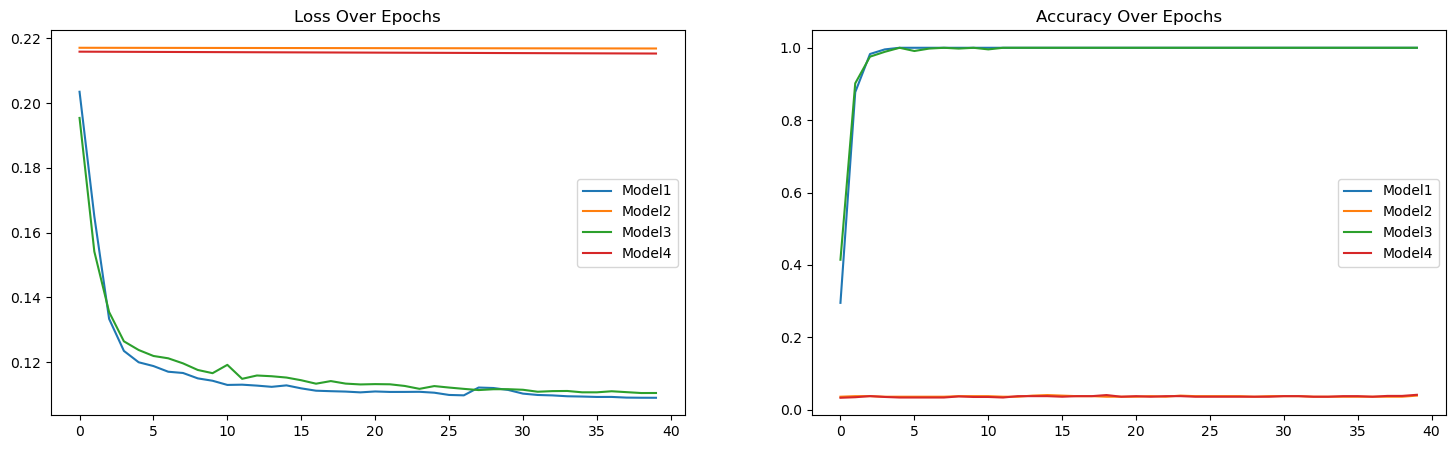

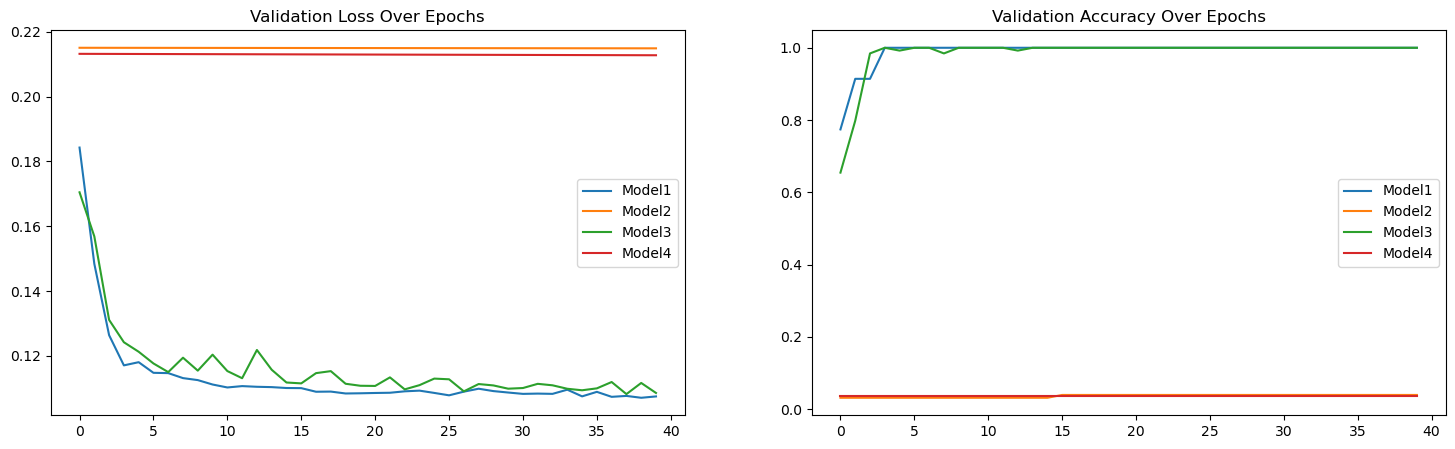

Final loss of Model1: 0.1075
Final loss of Model2: 0.2149
Final loss of Model3: 0.1085
Final loss of Model4: 0.2128
Final accuracy of Model1: 100.000%
Final accuracy of Model2: 4.587%
Final accuracy of Model3: 87.156%
Final accuracy of Model4: 3.670%


In [30]:
def test_model(optimizer):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128))
    ann.compile(optimizer=optimizer)
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(tf.keras.optimizers.Adam(learning_rate=0.0003))
Model2_history, Model2_accuracy = test_model(tf.keras.optimizers.SGD(learning_rate=0.0003))
Model3_history, Model3_accuracy = test_model(tf.keras.optimizers.RMSprop(learning_rate=0.0003))
Model4_history, Model4_accuracy = test_model(tf.keras.optimizers.Adagrad(learning_rate=0.0003))

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.plot(Model4_history.history['loss'], label='Model4')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.plot(Model4_history.history['accuracy'], label='Model4')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['val_loss'], label='Model1')
plt.plot(Model2_history.history['val_loss'], label='Model2')
plt.plot(Model3_history.history['val_loss'], label='Model3')
plt.plot(Model4_history.history['val_loss'], label='Model4')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['val_accuracy'], label='Model1')
plt.plot(Model2_history.history['val_accuracy'], label='Model2')
plt.plot(Model3_history.history['val_accuracy'], label='Model3')
plt.plot(Model4_history.history['val_accuracy'], label='Model4')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()
print("Final loss of Model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model4:", f"{Model4_history.history['val_loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")
print("Final accuracy of Model4:", f"{Model4_accuracy:.3f}%")

## 7.5 Set different epochs of ANN

Epoch 1/20


2023-12-13 14:01:56.747522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 54ms/step - loss: 0.1811 - accuracy: 0.5312 - val_loss: 0.1486 - val_accuracy: 0.7897
Epoch 2/20


2023-12-13 14:01:57.575941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 19ms/step - loss: 0.1352 - accuracy: 0.9605 - val_loss: 0.1359 - val_accuracy: 0.9453
Epoch 3/20
14/14 [==============================] - 0s 18ms/step - loss: 0.1326 - accuracy: 0.9777 - val_loss: 0.1264 - val_accuracy: 0.9766
Epoch 4/20
14/14 [==============================] - 0s 17ms/step - loss: 0.1204 - accuracy: 0.9978 - val_loss: 0.1163 - val_accuracy: 1.0000
Epoch 5/20
14/14 [==============================] - 0s 16ms/step - loss: 0.1176 - accuracy: 1.0000 - val_loss: 0.1143 - val_accuracy: 1.0000
Epoch 6/20
14/14 [==============================] - 0s 19ms/step - loss: 0.1160 - accuracy: 1.0000 - val_loss: 0.1142 - val_accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 0s 17ms/step - loss: 0.1166 - accuracy: 1.0000 - val_loss: 0.1128 - val_accuracy: 1.0000
Epoch 8/20
14/14 [==============================] - 0s 17ms/step - loss: 0.1172 - accuracy: 1.0000 - val_loss: 0.1158 - val_accuracy: 1.0000
Epoch 9/20
14/14 [======

2023-12-13 14:02:02.212936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 36ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

2023-12-13 14:02:03.023526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 55ms/step - loss: 0.1840 - accuracy: 0.5006 - val_loss: 0.1356 - val_accuracy: 0.8984
Epoch 2/40
 1/14 [=>............................] - ETA: 0s - loss: 0.1397 - accuracy: 0.9062

2023-12-13 14:02:03.858026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 21ms/step - loss: 0.1332 - accuracy: 0.9605 - val_loss: 0.1375 - val_accuracy: 0.8287
Epoch 3/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1322 - accuracy: 0.9509 - val_loss: 0.1256 - val_accuracy: 0.9922
Epoch 4/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1235 - accuracy: 0.9821 - val_loss: 0.1183 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1177 - accuracy: 0.9978 - val_loss: 0.1142 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1166 - accuracy: 1.0000 - val_loss: 0.1118 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1166 - accuracy: 0.9978 - val_loss: 0.1176 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1145 - accuracy: 1.0000 - val_loss: 0.1128 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-13 14:02:13.019614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 22ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       0.00       0.00       0.00       0.50         11
        14       0.15       1.00       0.27       0.95         

2023-12-13 14:02:13.778744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 59ms/step - loss: 0.1865 - accuracy: 0.4455 - val_loss: 0.1511 - val_accuracy: 0.8792
Epoch 2/60
 1/14 [=>............................] - ETA: 0s - loss: 0.1514 - accuracy: 0.9375

2023-12-13 14:02:14.697555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 22ms/step - loss: 0.1356 - accuracy: 0.9196 - val_loss: 0.1284 - val_accuracy: 0.9609
Epoch 3/60
14/14 [==============================] - 0s 17ms/step - loss: 0.1280 - accuracy: 0.9688 - val_loss: 0.1237 - val_accuracy: 0.9688
Epoch 4/60
14/14 [==============================] - 0s 19ms/step - loss: 0.1228 - accuracy: 0.9933 - val_loss: 0.1206 - val_accuracy: 0.9688
Epoch 5/60
14/14 [==============================] - 0s 17ms/step - loss: 0.1214 - accuracy: 0.9978 - val_loss: 0.1192 - val_accuracy: 1.0000
Epoch 6/60
14/14 [==============================] - 0s 17ms/step - loss: 0.1184 - accuracy: 0.9978 - val_loss: 0.1126 - val_accuracy: 1.0000
Epoch 7/60
14/14 [==============================] - 0s 18ms/step - loss: 0.1170 - accuracy: 0.9911 - val_loss: 0.1210 - val_accuracy: 0.9495
Epoch 8/60
14/14 [==============================] - 0s 26ms/step - loss: 0.1170 - accuracy: 0.9888 - val_loss: 0.1168 - val_accuracy: 1.0000
Epoch 9/60
14/14 [======

2023-12-13 14:02:28.823423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 16ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
 

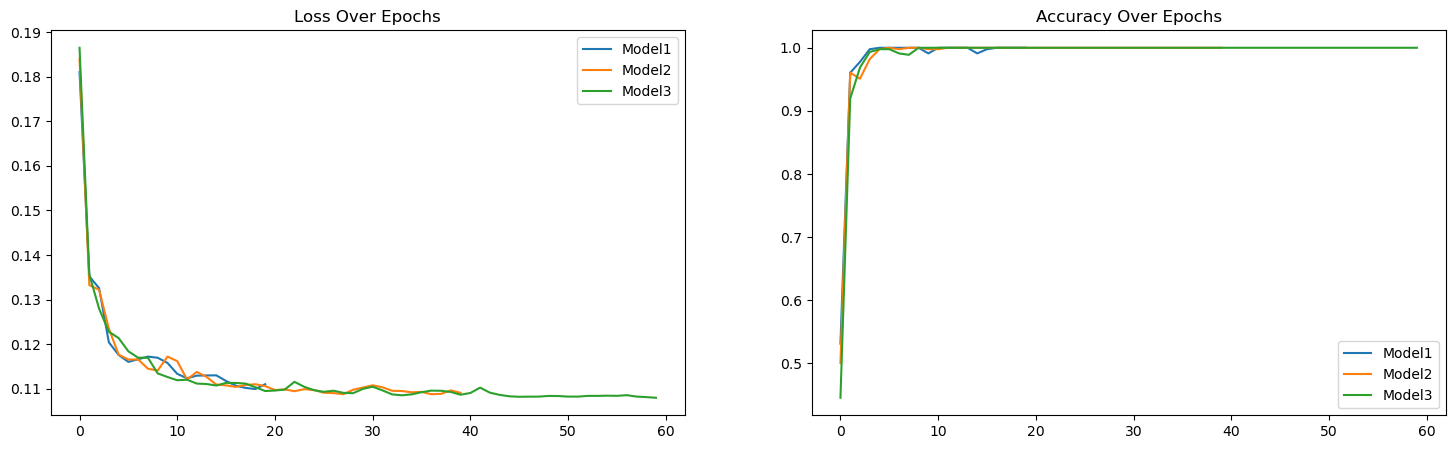

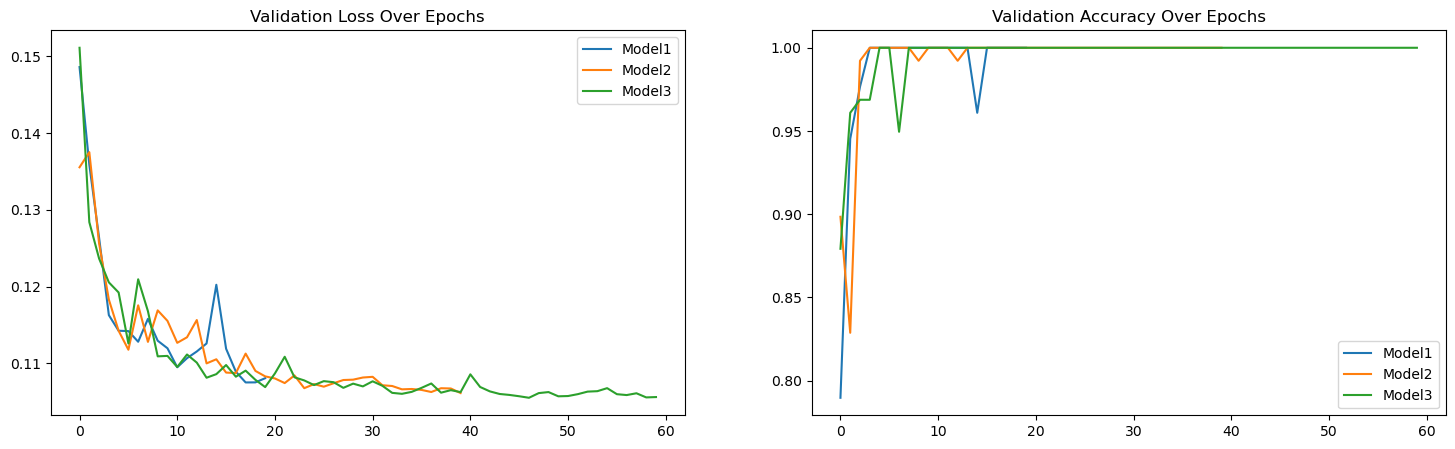

Final loss of Model1: 0.1081
Final loss of Model2: 0.1061
Final loss of Model3: 0.1056
Final accuracy of Model1: 98.165%
Final accuracy of Model2: 89.908%
Final accuracy of Model3: 100.000%


In [31]:
def test_model(epochs):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(20)
Model2_history, Model2_accuracy = test_model(40)
Model3_history, Model3_accuracy = test_model(60)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['val_loss'], label='Model1')
plt.plot(Model2_history.history['val_loss'], label='Model2')
plt.plot(Model3_history.history['val_loss'], label='Model3')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['val_accuracy'], label='Model1')
plt.plot(Model2_history.history['val_accuracy'], label='Model2')
plt.plot(Model3_history.history['val_accuracy'], label='Model3')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()
print("Final loss of Model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")

## 7.6 Set different number of components of GMM

In [32]:
def test_model(n_components):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    gmm = GMMClassifier(n_components=n_components)
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(2)
Model2_history, Model2_accuracy = test_model(8)
Model3_history, Model3_accuracy = test_model(16)
Model4_history, Model4_accuracy = test_model(y_train.shape[1])

print("Final loss of Model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model4:", f"{Model4_history.history['val_loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")
print("Final accuracy of Model4:", f"{Model4_accuracy:.3f}%")

Epoch 1/40


2023-12-13 14:02:30.058523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.3462

2023-12-13 14:02:31.126093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 68ms/step - loss: 0.2080 - accuracy: 0.3462 - val_loss: 0.1943 - val_accuracy: 0.4904
Epoch 2/40
14/14 [==============================] - 0s 23ms/step - loss: 0.1761 - accuracy: 0.7753 - val_loss: 0.1625 - val_accuracy: 0.7236
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1431 - accuracy: 0.9293 - val_loss: 0.1367 - val_accuracy: 0.8480
Epoch 4/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1315 - accuracy: 0.9538 - val_loss: 0.1237 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1227 - accuracy: 0.9955 - val_loss: 0.1160 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1189 - accuracy: 0.9955 - val_loss: 0.1159 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1166 - accuracy: 1.0000 - val_loss: 0.1129 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-13 14:02:40.787480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 65ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50         11
        14       0.00       0.00       0.00       0.50         

2023-12-13 14:02:41.623823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.2898

2023-12-13 14:02:42.709247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 67ms/step - loss: 0.2085 - accuracy: 0.2898 - val_loss: 0.1942 - val_accuracy: 0.4633
Epoch 2/40
14/14 [==============================] - 0s 24ms/step - loss: 0.1769 - accuracy: 0.7610 - val_loss: 0.1609 - val_accuracy: 0.8480
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1427 - accuracy: 0.9471 - val_loss: 0.1344 - val_accuracy: 0.9105
Epoch 4/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1259 - accuracy: 0.9888 - val_loss: 0.1223 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1224 - accuracy: 0.9978 - val_loss: 0.1202 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1208 - accuracy: 1.0000 - val_loss: 0.1155 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1178 - accuracy: 1.0000 - val_loss: 0.1154 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-13 14:02:52.595720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 37ms/step


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       1.00       1.00       1.00       1.00          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       1.00       1.00       1.00       1.00          2
        13       0.00       0.00       0.00       0.50         11
        14       1.00       1.00       1.00       1.00         

2023-12-13 14:02:53.322705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.2639

2023-12-13 14:02:54.444254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 70ms/step - loss: 0.2085 - accuracy: 0.2639 - val_loss: 0.1945 - val_accuracy: 0.4591
Epoch 2/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1762 - accuracy: 0.7507 - val_loss: 0.1573 - val_accuracy: 0.8558
Epoch 3/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1396 - accuracy: 0.9621 - val_loss: 0.1298 - val_accuracy: 0.9573
Epoch 4/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1258 - accuracy: 1.0000 - val_loss: 0.1225 - val_accuracy: 0.9922
Epoch 5/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1223 - accuracy: 1.0000 - val_loss: 0.1184 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1220 - accuracy: 0.9978 - val_loss: 0.1176 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1191 - accuracy: 1.0000 - val_loss: 0.1154 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-13 14:03:04.271164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 39ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       0.00       0.00       0.00       0.50          2
         3       1.00       1.00       1.00       1.00          2
         4       0.00       0.00       0.00       0.50          5
         5       1.00       1.00       1.00       1.00          1
         6       0.00       0.00       0.00       0.50          3
         7       1.00       1.00       1.00       1.00          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       1.00       1.00       1.00       1.00          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50         11
 

Epoch 1/40


2023-12-13 14:03:05.174696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 64ms/step - loss: 0.2078 - accuracy: 0.3153 - val_loss: 0.1940 - val_accuracy: 0.6304


2023-12-13 14:03:06.207117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/40
14/14 [==============================] - 0s 23ms/step - loss: 0.1752 - accuracy: 0.7908 - val_loss: 0.1651 - val_accuracy: 0.7975
Epoch 3/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1439 - accuracy: 0.9464 - val_loss: 0.1408 - val_accuracy: 0.8209
Epoch 4/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1270 - accuracy: 0.9799 - val_loss: 0.1259 - val_accuracy: 0.9141
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1210 - accuracy: 0.9978 - val_loss: 0.1191 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1188 - accuracy: 0.9978 - val_loss: 0.1175 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1184 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1159 - accuracy: 1.0000 - val_loss: 0.1116 - val_accuracy: 1.0000
Epoch 9/40
14

2023-12-13 14:03:16.139223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 33ms/step
Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
 

# 8. Final Model
In the final model, the ANN model has 4 hidden layers with 128 neurons per hidden layer, the learning rate of the optimizer is 0.001, the batch size is 32, and the number of epochs is 40.

In [51]:
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths, target_size=(32, 32))

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                    hidden_layers_sizes=(128, 128, 128, 128))
ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
gmm = GMMClassifier(n_components=y_train.shape[1])
ensemble = Ensemble(ann, gmm)

In [53]:
history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
y_pred = ensemble.predict(X_test)
y_test = np.argmax(y_test, axis=1)

Epoch 1/40


2023-12-13 14:06:41.956099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.1422

2023-12-13 14:06:43.201129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 73ms/step - loss: 0.2119 - accuracy: 0.1422 - val_loss: 0.2049 - val_accuracy: 0.2602
Epoch 2/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1991 - accuracy: 0.5065 - val_loss: 0.1919 - val_accuracy: 0.6226
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1830 - accuracy: 0.7372 - val_loss: 0.1765 - val_accuracy: 0.7272
Epoch 4/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1643 - accuracy: 0.9106 - val_loss: 0.1602 - val_accuracy: 0.8245
Epoch 5/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1474 - accuracy: 0.9710 - val_loss: 0.1441 - val_accuracy: 0.9141
Epoch 6/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1345 - accuracy: 0.9844 - val_loss: 0.1324 - val_accuracy: 0.9766
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1265 - accuracy: 0.9955 - val_loss: 0.1242 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-13 14:06:52.865797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 20ms/step


In [54]:
mapped_predictions = remap_labels(y_test, y_pred)

In [55]:
print("True labels:")
print(y_test)
print("Predicted labels:")
print(y_pred)
print("Remapped predicted labels:")
print(mapped_predictions)

True labels:
[13 22  7 23 23 12 20 12 12  0  8  2  4 12 23  2 15 25  3 19 12 21 15  0
 30  8  1  3  8  3 12  6 12 17 19 11 15 19 21 16  9 27  5 26 16 14  9 10
  7  9 31 29 12 12  3 13  8 16 14 23 30  6 10 30 19 23 17 28  0 18 11 12
 28 10 29 12 19 25 28 17 27  3 31 10  5  8  8 22 31  7  0 17  1 15 22 21
  7  0 31 30  5  8 14 24 16 27 24 17 26]
Predicted labels:
[ 3 19  8 31 31 30 24 30 30 21 29 17 15 30 31 17 23  6  5 26 30 11 23 21
 12 29 22  5 29  5 30 16 30 20 26  0 23 26 11 18 25  2 13 10 18 14 25  1
  8 25 28  4 30 30  5  3 29 18 14 31 12 16  1 12 26 31 20 27 21  7  0 30
 27  1  4 30 26  6 27 20  2  5 28  1 13 29 29 19 28  8 21 20 22 23 19 11
  8 21 28 12 13 29 14  9 18  2  9 20 10]
Remapped predicted labels:
[13 22  7 23 23 12 20 12 12  0  8  2  4 12 23  2 15 25  3 19 12 21 15  0
 30  8  1  3  8  3 12  6 12 17 19 11 15 19 21 16  9 27  5 26 16 14  9 10
  7  9 31 29 12 12  3 13  8 16 14 23 30  6 10 30 19 23 17 28  0 18 11 12
 28 10 29 12 19 25 28 17 27  3 31 10  5  8  8 22 31  7  0

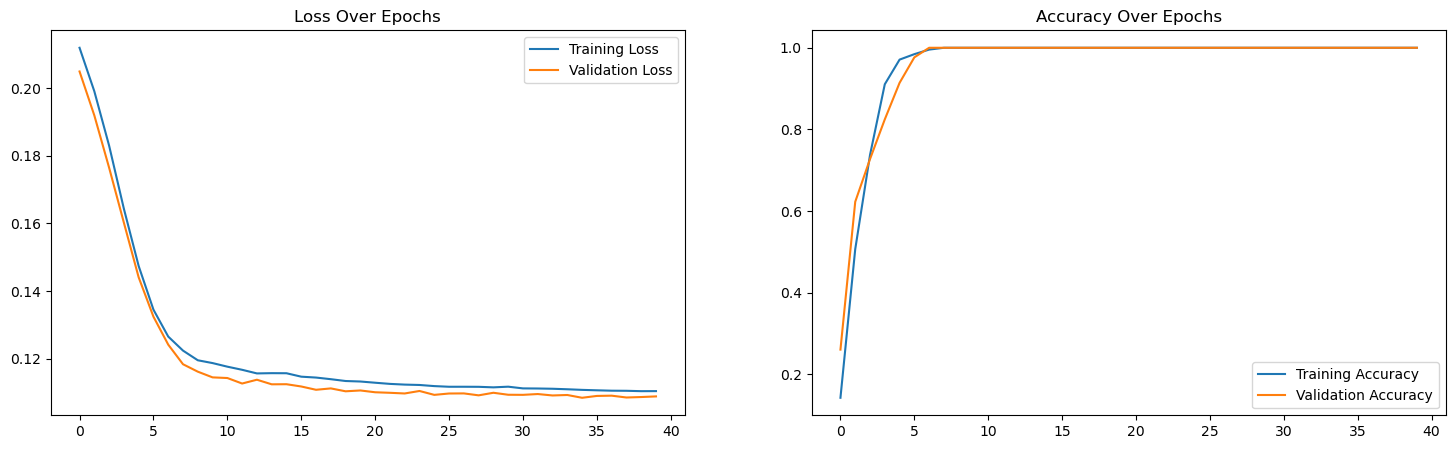

ANN Final cost: 0.11041215807199478
ANN Validation Loss: 0.10884645581245422
ANN Final accuracy: 1.0
ANN Validation accuracy: 1.0


In [56]:
plot_history(history)
print('ANN Final cost:', history.history['loss'][-1])
print('ANN Validation Loss:', history.history['val_loss'][-1])
print('ANN Final accuracy:', history.history['accuracy'][-1])
print('ANN Validation accuracy:', history.history['val_accuracy'][-1])

In [57]:
print(f"Accuracy: {custom_accuracy(y_test, mapped_predictions).numpy():.3f}%")

Accuracy: 100.000%


Model Report
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.00       1.00         

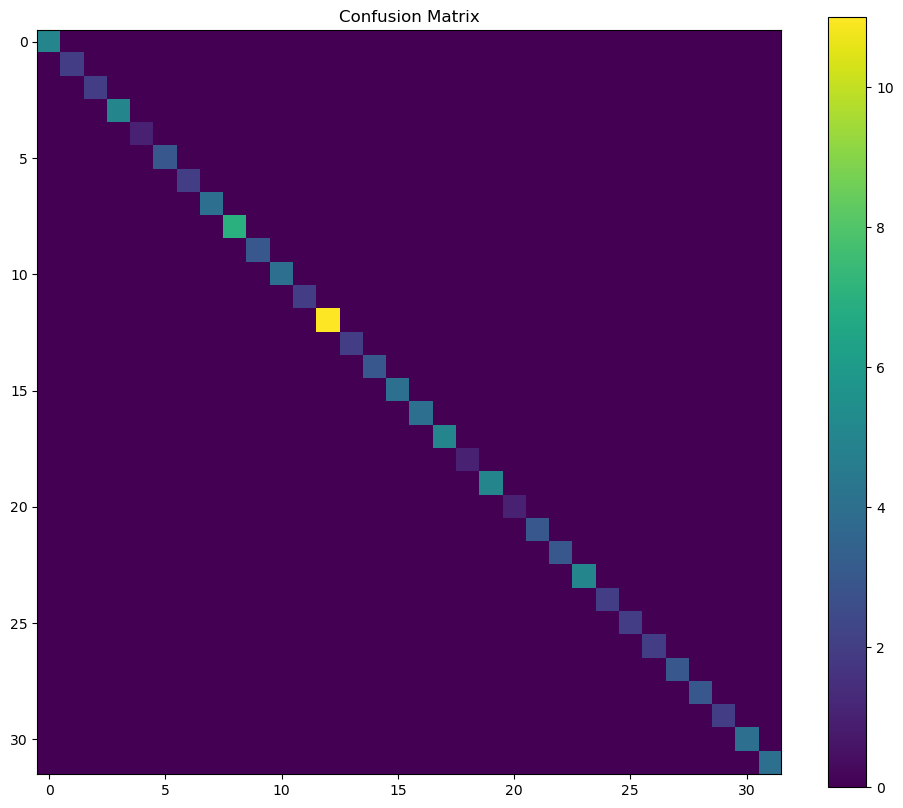

In [58]:
conf_matrix = confusion_matrix(y_test, mapped_predictions)
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

4/4 [==============================] - 0s 6ms/step


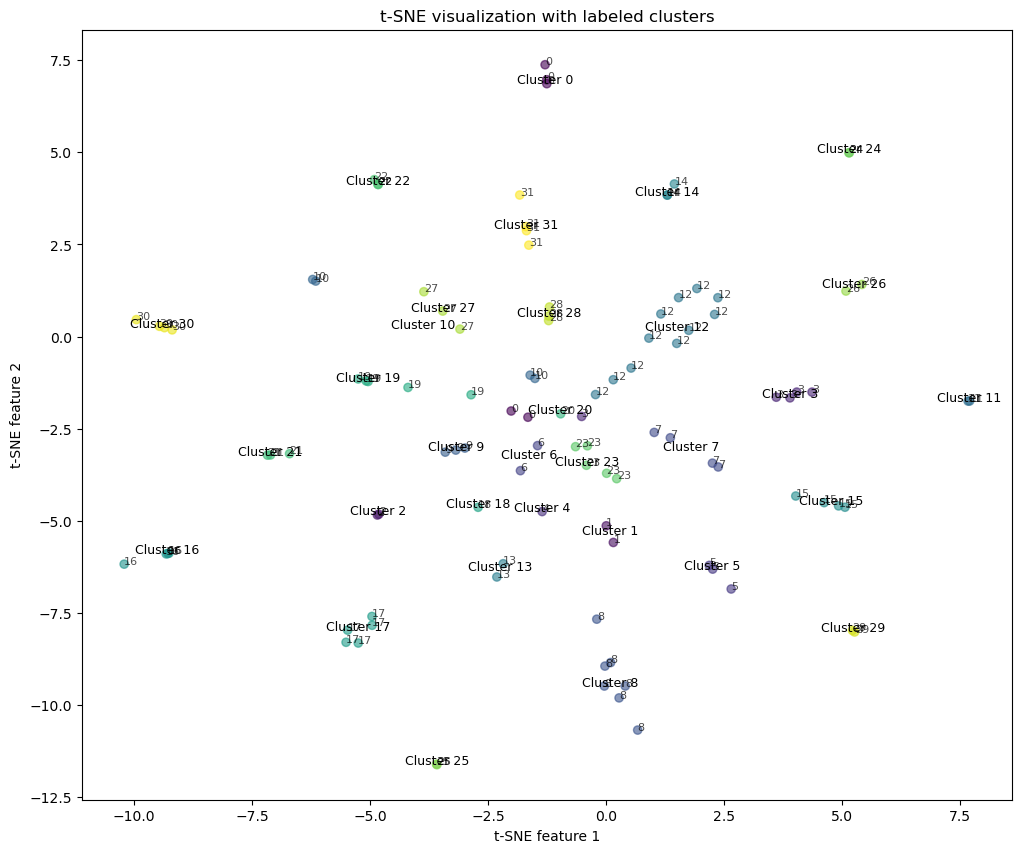

In [59]:
visualize_clusters_with_labels(X_test, mapped_predictions, ann)